In [1]:
#Run after kernel restart
import sys
print("sys:"+sys.version)
import transformers
print("transformers:"+transformers.__version__)
import datasets
print("datasets:"+datasets.__version__)
from datasets import load_dataset
import re
import hashlib
from transformers import AutoTokenizer
import torch
print("torch:"+torch.__version__)
from torch.utils.data import IterableDataset, Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
print("Done")

sys:3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:35:41) 
[Clang 16.0.6 ]
transformers:4.57.6
datasets:3.3.2
torch:2.8.0
Done


In [2]:
ds = load_dataset(
    "wikimedia/wikipedia",
    "20231101.en",
    split="train",
    streaming=True
)

sample = next(iter(ds))
print(type(sample))
print(sample.keys())
print(sample["text"][:300])

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

<class 'dict'>
dict_keys(['id', 'url', 'title', 'text'])
Anarchism is a political philosophy and movement that is skeptical of all justifications for authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy, typically including nation-states, and capitalism. Anarchism advocates for the replacement of the state 


In [4]:
def clean_text(text, min_words=50):
    if text is None:
        return None

    text = re.sub(r"\s+", " ", text).strip()

    text = text.lower()

    if len(text.split()) < min_words:
        return None

    return text

In [5]:
# Debug / Sanity Check: verify cleaned text quality
cleaned_count = 0

for sample in ds:
    cleaned = clean_text(sample["text"])
    if cleaned:
        print("CLEANED SAMPLE:")
        print(cleaned[:300])
        print("-" * 80)
        cleaned_count += 1

    if cleaned_count >= 3:
        break

CLEANED SAMPLE:
anarchism is a political philosophy and movement that is skeptical of all justifications for authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy, typically including nation-states, and capitalism. anarchism advocates for the replacement of the state 
--------------------------------------------------------------------------------
CLEANED SAMPLE:
albedo (; ) is the fraction of sunlight that is diffusely reflected by a body. it is measured on a scale from 0 (corresponding to a black body that absorbs all incident radiation) to 1 (corresponding to a body that reflects all incident radiation). surface albedo is defined as the ratio of radiosity
--------------------------------------------------------------------------------
CLEANED SAMPLE:
a, or a, is the first letter and the first vowel of the latin alphabet, used in the modern english alphabet, the alphabets of other western european languages and others worldwide. its nam

In [6]:
def is_duplicate(text, seen_hashes):
    h = hashlib.md5(text.encode("utf-8")).hexdigest()
    if h in seen_hashes:
        return True
    seen_hashes.add(h)
    return False

In [7]:
seen_hashes = set()
kept = 0

for sample in ds:
    cleaned = clean_text(sample["text"])
    if not cleaned:
        continue

    if is_duplicate(cleaned, seen_hashes):
        continue

    print(cleaned[:200])
    kept += 1

    if kept >= 3:
        break

anarchism is a political philosophy and movement that is skeptical of all justifications for authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy, typi
albedo (; ) is the fraction of sunlight that is diffusely reflected by a body. it is measured on a scale from 0 (corresponding to a black body that absorbs all incident radiation) to 1 (corresponding 
a, or a, is the first letter and the first vowel of the latin alphabet, used in the modern english alphabet, the alphabets of other western european languages and others worldwide. its name in english


In [8]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token


In [9]:
def chunk_token_ids(token_ids, block_size=512):
    for i in range(0, len(token_ids) - block_size + 1, block_size):
        yield token_ids[i:i + block_size]


In [10]:
def iter_token_blocks(ds, tokenizer, block_size=512, max_blocks=10):
    import hashlib

    seen_hashes = set()
    produced = 0

    for sample in ds:
        cleaned = clean_text(sample["text"])
        if not cleaned:
            continue

        h = hashlib.md5(cleaned.encode("utf-8")).hexdigest()
        if h in seen_hashes:
            continue
        seen_hashes.add(h)

        ids = tokenizer(cleaned, add_special_tokens=False)["input_ids"]

        # chunking
        for block in chunk_token_ids(ids, block_size=block_size):
            yield block
            produced += 1
            if produced >= max_blocks:
                return


In [11]:
blocks = list(iter_token_blocks(ds, tokenizer, block_size=128, max_blocks=3))

for i, b in enumerate(blocks):
    print(f"Block {i} length:", len(b))
    print("First 30 token ids:", b[:30])
    print("Decoded preview:", tokenizer.decode(b[:80]))
    print("-" * 60)


Token indices sequence length is longer than the specified maximum sequence length for this model (8524 > 1024). Running this sequence through the model will result in indexing errors


Block 0 length: 128
First 30 token ids: [272, 998, 1042, 318, 257, 1964, 8876, 290, 3356, 326, 318, 17988, 286, 477, 655, 6637, 329, 4934, 290, 12932, 284, 35531, 262, 6712, 340, 3667, 5529, 13114, 32000, 290]
Decoded preview: anarchism is a political philosophy and movement that is skeptical of all justifications for authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy, typically including nation-states, and capitalism. anarchism advocates for the replacement of the state with stateless societies and voluntary free associations. as a historically left-wing movement, this reading of anarchism is placed on the farthest left of the political
------------------------------------------------------------
Block 1 length: 128
First 30 token ids: [3812, 4934, 635, 8278, 13, 3584, 20675, 286, 26177, 4213, 389, 1043, 477, 3690, 2106, 11, 3660, 41661, 9349, 422, 262, 35957, 13, 1141, 262, 6846, 2063, 286, 262, 678]
Decoded preview:  toward authorit

In [12]:
class TokenBlockDataset(IterableDataset):
    def __init__(self, hf_ds, tokenizer, block_size=128, max_blocks=None):
        self.hf_ds = hf_ds
        self.tokenizer = tokenizer
        self.block_size = block_size
        self.max_blocks = max_blocks

    def __iter__(self):
        produced = 0
        for block in iter_token_blocks(
            self.hf_ds,
            self.tokenizer,
            block_size=self.block_size,
            max_blocks=self.max_blocks or 10**12
        ):
            t = torch.tensor(block, dtype=torch.long)
            yield t[:-1].contiguous(), t[1:].contiguous()

            produced += 1
            if self.max_blocks is not None and produced >= self.max_blocks:
                return

In [13]:
loader = DataLoader(
    TokenBlockDataset(ds, tokenizer, block_size=128, max_blocks=20000),
    batch_size=128,
    num_workers=0
)

x, y = next(iter(loader))
print(x.shape, y.shape)
print(x.device, y.device)


torch.Size([128, 127]) torch.Size([128, 127])
cpu cpu


In [14]:
def collate_pad(batch):
    return torch.nn.utils.rnn.pad_sequence(
        batch,
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )

In [15]:
# Assignment 2 Step 1: Generate token blocks for training

block_size = 128
max_blocks_train = 20000

train_blocks = []
for sample in ds:
    cleaned = clean_text(sample["text"])
    if not cleaned:
        continue

    token_ids = tokenizer.encode(cleaned)
    # 切 block
    for i in range(0, len(token_ids) - block_size, block_size):
        block = token_ids[i:i+block_size]
        if len(block) == block_size:
            train_blocks.append(torch.tensor(block, dtype=torch.long))

    if len(train_blocks) >= max_blocks_train:
        break

print("Training blocks:", len(train_blocks))

Training blocks: 20013


In [16]:
# Assignment 2 Step 2: next-token DataLoader（x,y）
class NextTokenDataset(Dataset):
    def __init__(self, blocks):
        self.blocks = blocks
    def __len__(self):
        return len(self.blocks)
    def __getitem__(self, idx):
        t = self.blocks[idx]
        x = t[:-1].contiguous()
        y = t[1:].contiguous()
        return x, y

train_ds = NextTokenDataset(train_blocks)

batch_size = 64
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

x, y = next(iter(train_loader))
print(x.shape, y.shape)


torch.Size([64, 127]) torch.Size([64, 127])


In [17]:
#Step 3：Accomplish mini-GPT
class CausalSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head, block_size, dropout=0.1):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        self.head_dim = n_embd // n_head

        self.qkv = nn.Linear(n_embd, 3 * n_embd)
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

        # causal mask
        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size)).unsqueeze(0).unsqueeze(0))

    def forward(self, x):
        B, T, C = x.size()
        qkv = self.qkv(x)  # [B,T,3C]
        q, k, v = qkv.split(C, dim=2)

        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)  # [B,h,T,hd]
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)      # [B,h,T,T]
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float("-inf"))
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)

        y = att @ v  # [B,h,T,hd]
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # [B,T,C]
        y = self.dropout(self.proj(y))
        return y

class Block(nn.Module):
    def __init__(self, n_embd, n_head, block_size, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.attn = CausalSelfAttention(n_embd, n_head, block_size, dropout)
        self.ln2 = nn.LayerNorm(n_embd)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.GELU(),
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class MiniGPT(nn.Module):
    def __init__(self, vocab_size, block_size, n_layer=2, n_embd=128, n_head=4, dropout=0.1):
        super().__init__()
        self.block_size = block_size
        self.tok_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb = nn.Embedding(block_size, n_embd)
        self.drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.size()
        pos = torch.arange(0, T, device=idx.device).unsqueeze(0)  # [1,T]

        x = self.tok_emb(idx) + self.pos_emb(pos)
        x = self.drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.ln_f(x)
        logits = self.head(x)  # [B,T,V]

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
        return logits, loss


device: mps
epoch 1: loss=7.3406, ppl=1541.69
epoch 2: loss=6.3486, ppl=571.70
saved: mini_gpt_checkpoint.pt


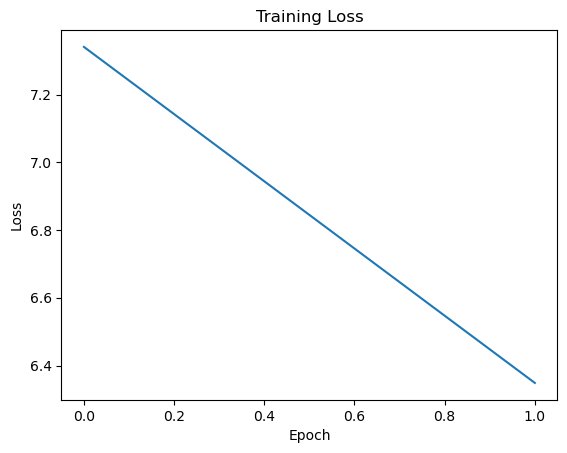

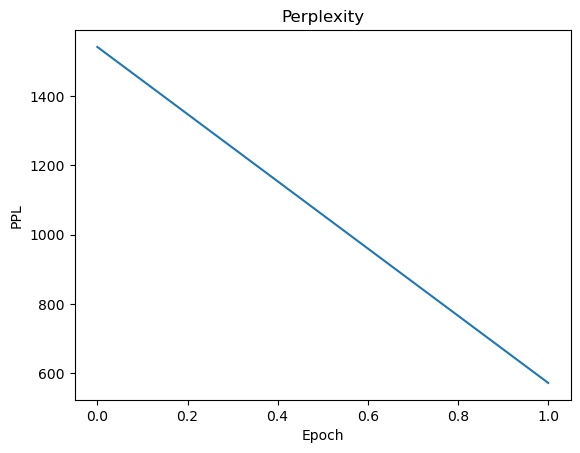

In [18]:
#Step 4：Training, checkpoint and diagram
device = "mps"
print("device:", device)

vocab_size = tokenizer.vocab_size
seq_len = block_size - 1
model = MiniGPT(vocab_size=vocab_size, block_size=seq_len, n_layer=2, n_embd=128, n_head=4).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
epochs = 2

loss_hist, ppl_hist = [], []

for ep in range(epochs):
    model.train()
    total_loss, n_batches = 0.0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        _, loss = model(x, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    avg_loss = total_loss / max(1, n_batches)
    ppl = math.exp(avg_loss)
    loss_hist.append(avg_loss)
    ppl_hist.append(ppl)

    print(f"epoch {ep+1}: loss={avg_loss:.4f}, ppl={ppl:.2f}")


ckpt_path = "mini_gpt_checkpoint.pt"
torch.save({
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "config": {"vocab_size": vocab_size, "block_size": seq_len, "n_layer": 2, "n_embd": 128, "n_head": 4},
    "loss_hist": loss_hist,
    "ppl_hist": ppl_hist,
}, ckpt_path)
print("saved:", ckpt_path)


plt.figure()
plt.plot(loss_hist)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(ppl_hist)
plt.title("Perplexity")
plt.xlabel("Epoch")
plt.ylabel("PPL")
plt.show()
